In [104]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error

## Creating Necessary Functions

In [105]:
def preprocess(df):
    """
    Preprocess the data removing uncessary data and setting elements to their correct types
    Handle Null values by backward fill null values
    Creating Features for our model training
    """
    if 'Unnamed: 0' in df.columns:
        df.drop(['Unnamed: 0'], axis=1, inplace=True)#remove empty column
    if df.index.name != 'Date':    
        df['Date'] = pd.to_datetime(df['Date']) #update column from string to datetime
        df.set_index('Date', inplace=True) 
        df = df.sort_index()
    df.fillna(method='bfill', inplace=True)
    return df

In [106]:
def feature_engineering(df):
    """
    Creating new features and concatentating other features
    Also using MinMaxScaler to Normalize the features between 0 and 1 to ensure large values are not weighted higher. 
    """
    df['Month'] = df.index.month #create a month feature to account for seasonality
    df['Week'] = df.index.isocalendar().week #create a week feature to account for seasonality
    df['Year'] = df.index.year
    df['Quarter'] = df.index.quarter 

    features_to_scale = ['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size']
    scaler = MinMaxScaler()
    df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
    df['Size_Type'] = df['Size'] * df['Type'] #concatenating the 2 highly correlated features in to one.

    return df

In [135]:
def add_lags(df):
    # Sort the DataFrame by 'Store', 'Dept', and 'Date' (assuming 'Date' is index)
    df = df.sort_values(by=['Store', 'Dept', 'Date'])

    # Define a function to add lagged features
    def add_lag_feature(df, lag_weeks, lag_name):
        df[lag_name] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(periods=lag_weeks)
        return df

    # Add lag features
    df = add_lag_feature(df, 1, 'lag1')   # 1 week back
    df = add_lag_feature(df, 5, 'lag2')   # 5 weeks back (1 month approx)
    df = add_lag_feature(df, 52, 'lag3')  # 1 year back

    return df

In [108]:
df = pd.read_csv('../data/walmart_data.csv')
df = preprocess(df)

C:\Users\nmarr\AppData\Local\Temp\ipykernel_28232\3351921570.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


## Training With Cross-Validation

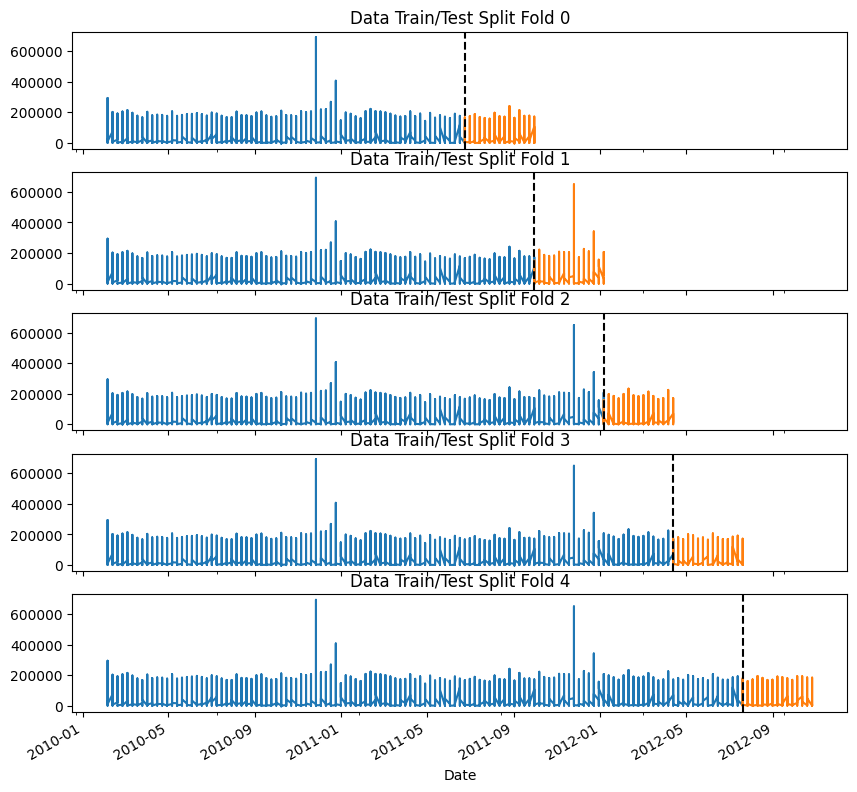

In [109]:
tss = TimeSeriesSplit(n_splits=5, test_size=42000)
df = df.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True)
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Weekly_Sales'].plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}')
    test['Weekly_Sales'].plot(ax=axs[fold], label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()


In [110]:
df = feature_engineering(df)
df = add_lags(df)
features = ['Store', 'Size_Type', 'Dept', 'IsHoliday', 'CPI', 'Unemployment', 'Month', 'Week', 'Year', 'Quarter', 'lag1', 'lag2', 'lag3']
target = 'Weekly_Sales'

tss = TimeSeriesSplit(n_splits=5, test_size=42000)
fold = 0
preds, scores = [], {'MAE': [], 'MSE': [], 'RMSE': []}
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=1000, max_depth=3,
                            early_stopping_rounds=100, objective='reg:squarederror', learning_rate=0.01)
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    scores['MAE'].append(mean_absolute_error(y_test, y_pred))
    scores['MSE'].append(mean_squared_error(y_test, y_pred))
    scores['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_pred)))

[0]	validation_0-rmse:30261.85289	validation_1-rmse:24741.23595
[100]	validation_0-rmse:13075.83354	validation_1-rmse:10641.28157
[200]	validation_0-rmse:7907.54722	validation_1-rmse:6603.89848
[300]	validation_0-rmse:6598.52154	validation_1-rmse:5653.95680
[400]	validation_0-rmse:6203.44967	validation_1-rmse:5361.58557
[500]	validation_0-rmse:5999.89400	validation_1-rmse:5211.04156
[600]	validation_0-rmse:5864.04187	validation_1-rmse:5118.26058
[700]	validation_0-rmse:5774.25552	validation_1-rmse:5062.22566
[800]	validation_0-rmse:5700.76527	validation_1-rmse:5014.00477
[900]	validation_0-rmse:5653.53198	validation_1-rmse:4979.90163
[999]	validation_0-rmse:5610.96268	validation_1-rmse:4950.47019
[0]	validation_0-rmse:29420.02574	validation_1-rmse:27543.41426
[100]	validation_0-rmse:12755.41269	validation_1-rmse:11885.13269
[200]	validation_0-rmse:7749.50360	validation_1-rmse:7411.20412
[300]	validation_0-rmse:6484.95573	validation_1-rmse:6363.30293
[400]	validation_0-rmse:6097.30508	v

In [111]:
mean_mae = np.mean(scores['MAE'])
mean_mse = np.mean(scores['MSE'])
mean_rmse = np.mean(scores['RMSE'])

print(f'Fold Scores - Mean Absolute Error: {scores["MAE"]}')
print(f'Fold Scores - Mean Squared Error: {scores["MSE"]}')
print(f'Fold Scores - Root Mean Absolute Error: {scores["RMSE"]}')
print(f'Mean Absolute Error: {mean_mae}')
print(f'Mean Squared Error: {mean_mse}')
print(f'Root Mean Absolute Error: {mean_rmse}')



Fold Scores - Mean Absolute Error: [1949.0065924189782, 2096.852973571359, 1604.8883185476282, 1411.0742204801525, 1480.9978904277896]
Fold Scores - Mean Squared Error: [24507155.558806416, 31757185.63454212, 14298219.958608646, 26395302.818023596, 14486358.69359238]
Fold Scores - Root Mean Absolute Error: [4950.470236129737, 5635.351420678405, 3781.298713221245, 5137.635917231153, 3806.094940170618]
Mean Absolute Error: 1708.5639990891818
Mean Squared Error: 22288844.53271463
Root Mean Absolute Error: 4662.170245486232


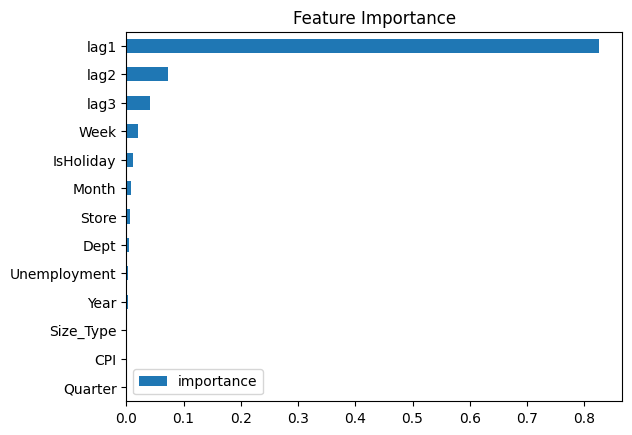

In [112]:
feature_importance = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_,
                                  columns=['importance'])
feature_importance.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [157]:
X_test.shape

(42000, 13)

In [158]:
X_train.shape

(379570, 13)

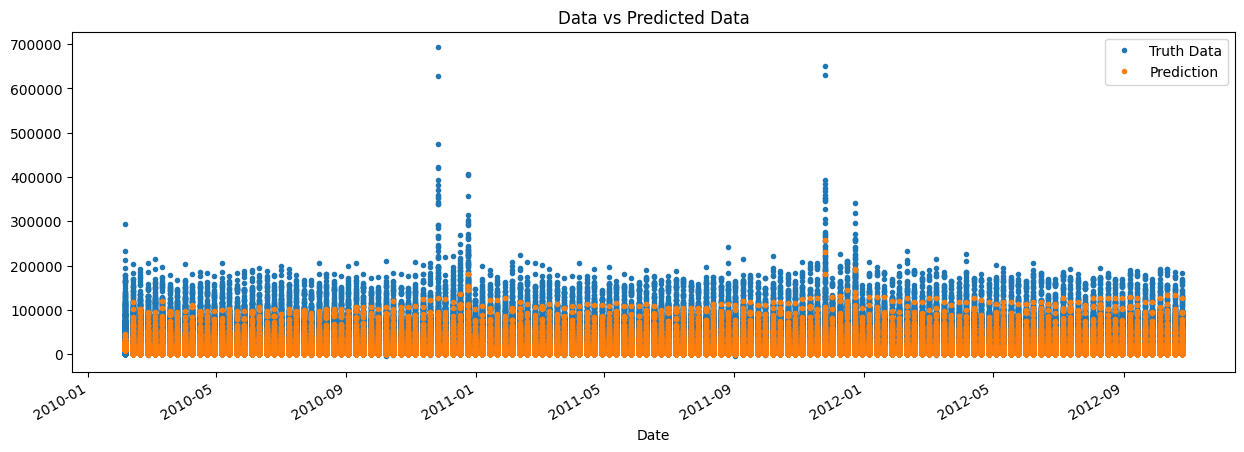

In [159]:
prediction = reg.predict(X_test)
prediction_series = pd.Series(prediction, index=X_test.index)
ax = df['Weekly_Sales'].plot(figsize=(15, 5), label='Truth Data', style='.')
prediction_series.plot(ax=ax, style='.', label='Prediction')
plt.legend()
plt.title('Data vs Predicted Data')
plt.show()

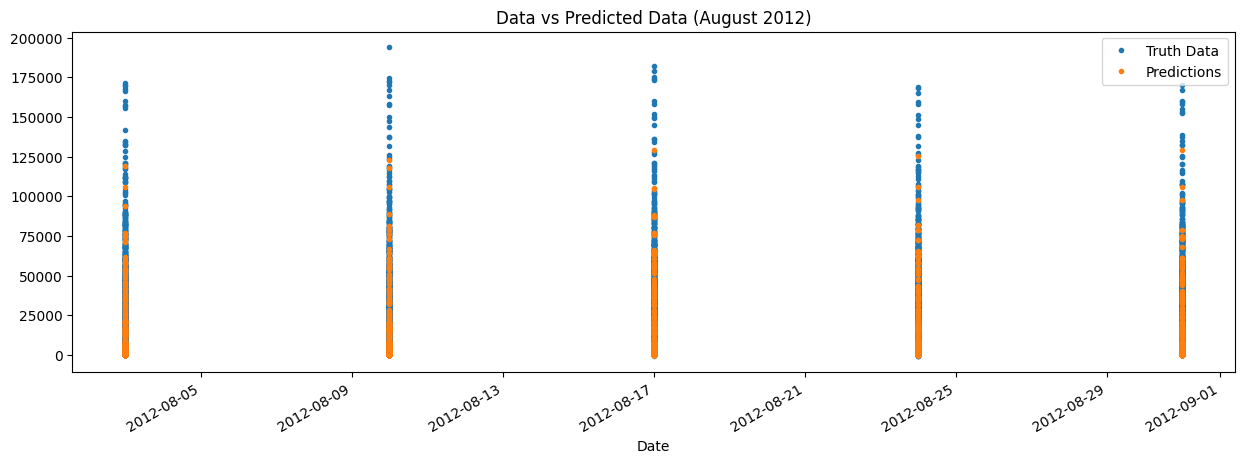

In [153]:
# Filter data from 2012-08
start_date = '2012-08-01'
end_date = '2012-09-01'
filtered_df = df[(df.index >= start_date) & (df.index <= end_date)]
filtered_prediction_series = prediction_series[(prediction_series.index >= start_date) & (prediction_series.index <= end_date)]

ax = filtered_df['Weekly_Sales'].plot(figsize=(15, 5), label='Truth Data', style='.')
filtered_prediction_series.plot(ax=ax, style='.', label='Predictions')

plt.legend()
plt.title('Data vs Predicted Data (August 2012)')
plt.show()

## Predicting On Future Data

In [121]:
df = pd.read_csv('../data/walmart_data.csv')
df = preprocess(df)
df = feature_engineering(df)
df = add_lags(df)

features = ['Store', 'Size_Type', 'Dept', 'IsHoliday', 'CPI', 'Unemployment', 'Month', 'Week', 'Year', 'Quarter', 'lag1', 'lag2', 'lag3']
target = 'Weekly_Sales'

X_all = df[features]
y_all = df[target]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=500, objective='reg:squarederror', learning_rate=0.01)
reg.fit(X_all, y_all, eval_set=[(X_all, y_all)], verbose=200)

C:\Users\nmarr\AppData\Local\Temp\ipykernel_28232\3351921570.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


[0]	validation_0-rmse:27505.71065
[200]	validation_0-rmse:6372.48950
[400]	validation_0-rmse:4790.30782
[499]	validation_0-rmse:4528.34459


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [122]:
df.index.max()

Timestamp('2012-10-26 00:00:00')

In [137]:
future = pd.date_range('2012-10-26', '2013-02-26', freq='1W')
future_df = pd.DataFrame()
future_df['Date'] = future
future_df.set_index('Date', inplace=True)
future_df['isFuture'] = True

df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = feature_engineering(df_and_future)
df_and_future = add_lags(df_and_future)
df_and_future.head()

,Store,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Size,Month,Week,Year,Quarter,Size_Type,lag1,lag2,lag3,isFuture
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1.0,0.0,1.0,24924.50,0.434149,0.050100,0.0,0.002536,0.000205,0.0,...,0.630267,2,5,2010,1,1.890802,NaN,NaN,NaN,False
2010-02-12,1.0,1.0,1.0,46039.49,0.396967,0.038076,0.0,0.002536,0.000205,0.0,...,0.630267,2,6,2010,1,1.890802,24924.50,NaN,NaN,False
2010-02-19,1.0,0.0,1.0,41595.55,0.410861,0.021042,0.0,0.002536,0.000205,0.0,...,0.630267,2,7,2010,1,1.890802,46039.49,NaN,NaN,False
2010-02-26,1.0,0.0,1.0,19403.54,0.476419,0.044589,0.0,0.002536,0.000205,0.0,...,0.630267,2,8,2010,1,1.890802,41595.55,NaN,NaN,False
2010-03-05,1.0,0.0,1.0,21827.90,0.475147,0.076653,0.0,0.002536,0.000205,0.0,...,0.630267,3,9,2010,1,1.890802,19403.54,NaN,NaN,False


In [155]:
future_w_features = df_and_future.query('isFuture').copy()
start_date, end_date = '2011-10-26', '2012-02-26'
filtered_df = df[(df.index >= start_date) & (df.index <= end_date)]

future_w_features['Store'] = 28
future_w_features['Size_Type'] = 2.783704
future_w_features['Dept'] = 44
future_w_features['IsHoliday'] = filtered_df['IsHoliday'].mean()
future_w_features['CPI'] = filtered_df['CPI'].mean()
future_w_features['Unemployment'] = filtered_df['Unemployment'].mean()
future_w_features.head()

,Store,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Size,Month,Week,Year,Quarter,Size_Type,lag1,lag2,lag3,isFuture
Date,,,,,,,,,,,,,,,,,,,,,
2012-10-28,28,0.168038,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,10,43,2012,4,2.783704,NaN,NaN,NaN,True
2012-11-04,28,0.168038,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,11,44,2012,4,2.783704,NaN,NaN,NaN,True
2012-11-11,28,0.168038,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,11,45,2012,4,2.783704,NaN,NaN,NaN,True
2012-11-18,28,0.168038,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,11,46,2012,4,2.783704,NaN,NaN,NaN,True
2012-11-25,28,0.168038,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,11,47,2012,4,2.783704,NaN,NaN,NaN,True


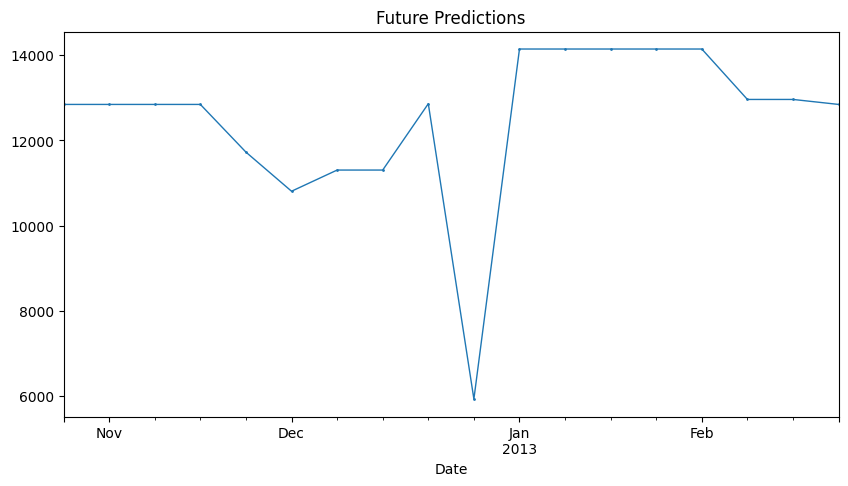

In [156]:
future_w_features['pred'] = reg.predict(future_w_features[features])
future_w_features['pred'].plot(figsize=(10,5), ms=1, lw=1, title='Future Predictions', marker='o', linestyle='-')
plt.show()

In [145]:
df.head()

,Store,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Size,Month,Week,Year,Quarter,Size_Type,lag1,lag2,lag3,isFuture
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,0,1.0,24924.50,0.434149,0.050100,0.0,0.002536,0.000205,0.0,...,0.630267,2,5,2010,1,1.890802,NaN,NaN,NaN,False
2010-02-12,1,1,1.0,46039.49,0.396967,0.038076,0.0,0.002536,0.000205,0.0,...,0.630267,2,6,2010,1,1.890802,24924.50,NaN,NaN,False
2010-02-19,1,0,1.0,41595.55,0.410861,0.021042,0.0,0.002536,0.000205,0.0,...,0.630267,2,7,2010,1,1.890802,46039.49,NaN,NaN,False
2010-02-26,1,0,1.0,19403.54,0.476419,0.044589,0.0,0.002536,0.000205,0.0,...,0.630267,2,8,2010,1,1.890802,41595.55,NaN,NaN,False
2010-03-05,1,0,1.0,21827.90,0.475147,0.076653,0.0,0.002536,0.000205,0.0,...,0.630267,3,9,2010,1,1.890802,19403.54,NaN,NaN,False


            Store  IsHoliday  Dept  Weekly_Sales  Temperature  Fuel_Price  \
Date                                                                        
2010-10-29     28          0  44.0       5182.84     0.617906    0.272545   
2010-11-05     28          0  44.0       4772.54     0.660959    0.329158   
2010-11-12     28          0  44.0       4944.65     0.585616    0.329659   
2010-11-19     28          0  44.0       3583.53     0.589432    0.345190   
2010-11-26     28          1  44.0       6643.84     0.486497    0.345691   
2010-12-03     28          0  44.0       5462.05     0.444129    0.285070   
2010-12-10     28          0  44.0       5484.73     0.509491    0.366232   
2010-12-17     28          0  44.0       6639.71     0.536497    0.382766   
2010-12-24     28          0  44.0      10179.60     0.529159    0.382766   
2010-12-31     28          1  44.0       3347.35     0.466732    0.338677   
2011-01-07     28          0  44.0       3838.16     0.388454    0.408317   

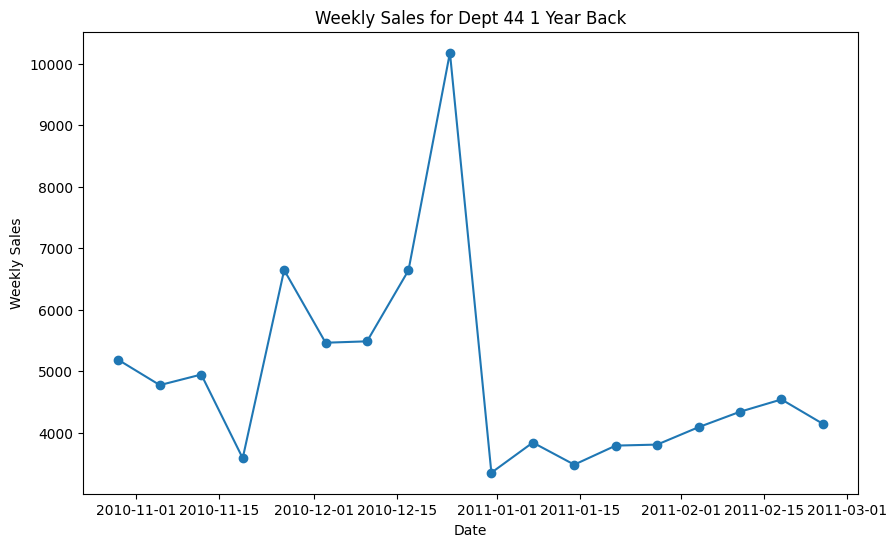

In [150]:
# Applying the mask
mask = (df.index >= '2010-10-26') & (df.index <= '2011-02-26') & (df['Dept']==44) & (df['Store']==28)
selected_data = df.loc[mask]

plt.figure(figsize=(10, 6))
plt.plot(selected_data.index, selected_data['Weekly_Sales'], marker='o', linestyle='-')
plt.title('Weekly Sales for Dept 44 1 Year Back')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()